This notebook compares the results of genome-wide boundary CTCF perturbations with DNA shape.

First, in silico perturbation results are loaded from h5 and filtered based on whether a given boundary was responsive to CTCF motif permutation.

Sites are further filtered to have similar jaspar CTCF scores for the core motif.

Sequences around each site are loaded and converted to DNA shape.

The propeller twist (proT) is somewhat different between motifs that have strong & weak effects on SCD/insulation, but not as dramatically as when no restriction is placed on the core motif Jaspar score. However, this likely just reflects different GC content ~10bp upstream of strong motifs.


In [1]:
import matplotlib.pyplot as plt
import bioframe
import pandas as pd
import numpy as np
import h5py
import os
from scipy.stats import spearmanr, pearsonr
from io import StringIO
import pysam
import akita_utils.h5_utils
import glob


from matplotlib import colors

cmap_purple_green_GC = colors.ListedColormap(
    ["mistyrose", "darkseagreen", "plum", "beige"]  # a  # c  # g  # t
)
cmap_rhee = colors.ListedColormap(
    ["red", "blue", "yellow", "green"]  # a red  # c blue  # g yllow  # t green
)

cmaps = [cmap_purple_green_GC, cmap_rhee]

In [2]:
from akita_utils.format_io import h5_to_df
from akita_utils.tsv_gen_utils import filter_by_chrmlen, filter_boundary_ctcfs_from_h5, filter_by_overlap_num
from akita_utils.dna_utils import (
    dna_1hot,
    dna_1hot_index,
    dna_1hot_GC,
    dna_rc,
)

### Load & filter genomic deletion SCD for boundary CTCFs

In [3]:
def h5_to_dfs_dict(h5_dirs, stats, models=[0,1,2,3,4,5,6,7], head=1): # TODO: check repeated model numbers
    models_dict = {} 
    for h5_num, h5_file in enumerate(glob.glob(h5_dirs)):
        for model in models:
            if f"model{model}_head{head}" in h5_file:
                df = akita_utils.format_io.h5_to_df(h5_file, drop_duplicates_key=None)
                if f"h{head}_m{model}" in models_dict.keys():
                    models_dict[f"h{head}_m{model}"] = pd.concat([model_dfs[f"h{head}_m{model}"], df])
                else:
                    models_dict[f"h{head}_m{model}"] = df 
    return models_dict
    

def calculate_mean_stats_across_models(models_dict, stats):
    dfs = []
    df = pd.DataFrame()
    for model in models_dict.values():
        dfs.append(model)
    
    for stat in stats:
        df[stat] = np.mean([df[stat] for df in dfs], axis=0)
    return df
        

In [28]:
h5_dirs = ("/scratch1/kamulege/disruption_genomic_scds_v2/*/scd.h5")
# h5_dirs = ("/scratch1/kamulege/disruption_genomic_scds/*/scd.h5")
df_dict = h5_to_dfs_dict(h5_dirs, stats=["SCD", "SSD"], models=[4])

merged_df = calculate_mean_stats_across_models(df_dict, stats=["SCD", "SSD"])
    
merged_df[-10:]

,SCD,SSD
26376,0.180176,0.180176
26377,0.202026,0.202026
26378,22.625000,22.625000
26379,39.812500,39.812500
26380,38.343750,38.343750
26381,0.188843,0.188843
26382,0.094727,0.094727
26383,0.047943,0.047943
26384,0.229370,0.229370
26385,5.988281,5.988281


In [5]:
df = filter_boundary_ctcfs_from_h5(
    # h5_dirs="/project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model*/scd.h5",
    h5_dirs="/scratch1/kamulege/disruption_genomic_scds_v2/motif_expt_model*_head1/scd.h5",
    score_key="SCD",
    threshold_all_ctcf=5,
)

annotating each site with boundary-wide scores


In [6]:
df.shape

(7308, 23)

In [7]:
# akita_utils.h5_utils.collect_h5("scd.h5", "/scratch1/kamulege/disruption_genomic_scds_v2/motif_expt_model4_head1", 100)

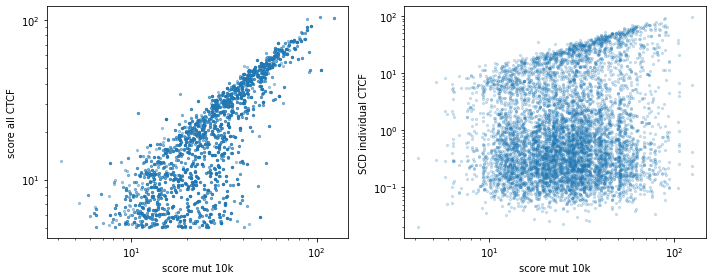

In [8]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(df["score_10k"], df["score_all_ctcf"], 5, alpha=0.2)
plt.loglog()
plt.xlabel("score mut 10k")
plt.ylabel("score all CTCF")

plt.subplot(122)
plt.scatter(df["score_10k"], df["SCD"], 5, alpha=0.2)
plt.loglog()
plt.xlabel("score mut 10k")
plt.ylabel("SCD individual CTCF")
plt.tight_layout()

In [9]:

rmsk = akita_utils.format_io.read_rmsk("/project/fudenber_735/genomes/mm10/database/rmsk.txt.gz")
sites = filter_by_overlap_num(df, rmsk, working_df_cols=["chrom", "start_2", "end_2"])

# sites.head

In [10]:
# df.columns

In [11]:
## add scores for jaspar core motif to table of sites
ctcf_motifs = bioframe.read_table(
    "/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz",
    schema="jaspar",
    skiprows=1,
)
sites = sites.merge(
    ctcf_motifs,
    how="left",
    left_on=["chrom", "start_2", "end_2"],
    right_on=["chrom", "start", "end"],
)

sites_unfiltered = sites.copy()

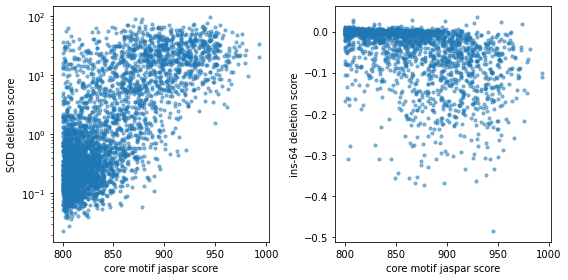

In [12]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(sites["score"], sites["SCD"], 10, alpha=0.5)
plt.semilogy()
plt.xlabel("core motif jaspar score")
plt.ylabel("SCD deletion score")

plt.subplot(122)
plt.scatter(sites["score"], sites["INS-64"], 10, alpha=0.5)
plt.xlabel("core motif jaspar score")
plt.ylabel("ins-64 deletion score")

plt.tight_layout()

In [13]:
## get sites with similar core motif strengths
# sites = sites.query('(score > 800) and (score < 850)')

sites = sites_unfiltered.query("(score > 850) and (score < 875)").copy()
sites.reset_index(drop=True, inplace=True)

In [14]:
## split sites by strong vs weak, here using insulation score (ins-64)
num_sites = 100
sites_weak = sites["INS-64"].values > -0.01
sites_strong = sites["INS-64"].values < -0.03

sites_weak = np.where(sites_weak)[0]
sites_strong = np.where(sites_strong)[0]
print("num weak", len(sites_weak), ", num strong", len(sites_strong))

sites_weak = sites_weak[
    np.sort(np.random.choice(len(sites_weak), num_sites, replace=False))
]
sites_strong = sites_strong[
    np.sort(np.random.choice(len(sites_strong), num_sites, replace=False))
]
sites_strong = sites.loc[sites_strong].reset_index(drop=True)
sites_weak = sites.loc[sites_weak].reset_index(drop=True)

num weak 214 , num strong 134


In [15]:
def get_seqs(
    sites,
    genome_file="/project/fudenber_735/genomes/mm10/mm10.fa",
    extent_bp=100,
    verbose=False,
):
    """
    Get and orient DNA sequence around motifs, and return arrays with various transformation:
    into 1hot, index, and binary (GC).
    """
    genome_open = pysam.Fastafile(genome_file)

    seqs = []
    seqs_1hot = []
    seqs_index = []
    seqs_GC = []
    for i in range(len(sites)):
        if verbose:
            if np.mod(i, 50) == 0:
                print(i)
        chrm, start, end, strand = sites.loc[i][
            ["chrom", "start_2", "end_2", "strand_2"]
        ]
        start = start - extent_bp
        end = end + extent_bp
        seq = genome_open.fetch(chrm, start, end).upper()
        if strand == "-":
            seq = dna_rc(seq)
        seqs.append(seq)
        seqs_1hot.append(dna_1hot(seq))
        seqs_index.append(dna_1hot_index(seq))
        seqs_GC.append(dna_1hot_GC(seq))
    seqs_index = np.array(seqs_index)
    seqs_GC = np.array(seqs_GC)
    seqs_1hot = np.array(seqs_1hot)
    return seqs, seqs_1hot, seqs_index, seqs_GC

In [16]:
seqs_weak, seqs_1hot_weak, seqs_index_weak, seqs_GC_weak = get_seqs(
    sites_weak, genome_file="/project/fudenber_735/genomes/mm10/mm10.fa", extent_bp=100
)
seqs_strong, seqs_1hot_strong, seqs_index_strong, seqs_GC_strong = get_seqs(
    sites_strong,
    genome_file="/project/fudenber_735/genomes/mm10/mm10.fa",
    extent_bp=100,
)

In [17]:
#### load in Rohs lab DNA shape table
dnashape = pd.read_excel(
    "/project/fudenber_735/motifs/DNA shape query table.xlsx", skipfooter=4
)
dnashape_dict = dnashape.set_index("Pentamer")  # .loc['AAAAAA']
dnashape_rc = dnashape.copy()
for i in range(len(dnashape)):
    dnashape_rc.loc[i, "Pentamer"] = dna_rc(dnashape_rc.loc[i, "Pentamer"])
dnashape_dict = pd.concat([dnashape, dnashape_rc])
dnashape_dict = dnashape_dict.set_index("Pentamer")

In [18]:
PENTAMER_LEN = 5


def shape_converter(seq, shape_key="MGW"):
    shape_vec = []
    for i in range(len(seq) - PENTAMER_LEN):
        subseq = seq[i : i + PENTAMER_LEN]
        if "N" in subseq:
            shape_vec.append(np.nan)
        else:
            shape_vec.append(dnashape_dict[shape_key].loc[subseq])
    return np.array(shape_vec)


def shape_converter_multi(seq_list, shape_key="MGW"):
    shape_mat = []
    for seq in seq_list:
        shape_mat.append(shape_converter(seq, shape_key))
    return np.array(shape_mat)

In [19]:
shape_val_dict = {}
for shape_key in dnashape.keys()[1:]:
    shape_weak = shape_converter_multi(seqs_weak, shape_key=shape_key)
    shape_strong = shape_converter_multi(seqs_strong, shape_key=shape_key)
    shape_val_dict[shape_key] = [shape_weak, shape_strong]

In [20]:
shape_corrs = {}
bp_start, bp_stop = 80, 139
inds_no_center = np.hstack((np.arange(20), np.arange(39, bp_stop - bp_start)))

for shape_key in dnashape.keys()[1:]:
    weak_shape, strong_shape = shape_val_dict[shape_key]

    shape_corrs[shape_key] = [
        np.round(
            spearmanr(
                np.nanmean(weak_shape[:, bp_start:bp_stop], axis=0)[inds_no_center],
                np.nanmean(strong_shape[:, bp_start:bp_stop], axis=0)[inds_no_center],
            )[0],
            2,
        ),
        np.round(
            np.sum(
                np.abs(
                    np.nanmean(weak_shape[:, bp_start:bp_stop], axis=0)[inds_no_center]
                    - np.nanmean(strong_shape[:, bp_start:bp_stop], axis=0)[
                        inds_no_center
                    ]
                )
            ),
            2,
        ),
    ]

Text(0, 0.5, 'total diff')

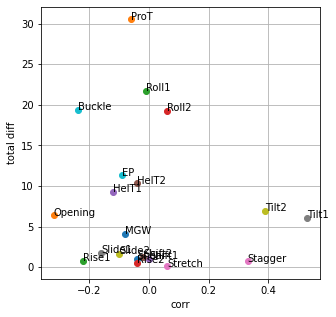

In [21]:
plt.figure(figsize=(5, 5))
for k, v in shape_corrs.items():
    plt.plot(v[0], v[1], "o")
    plt.text(v[0], v[1], k)
plt.grid()
plt.xlabel("corr")
plt.ylabel("total diff")

MGW 4.33 5.69


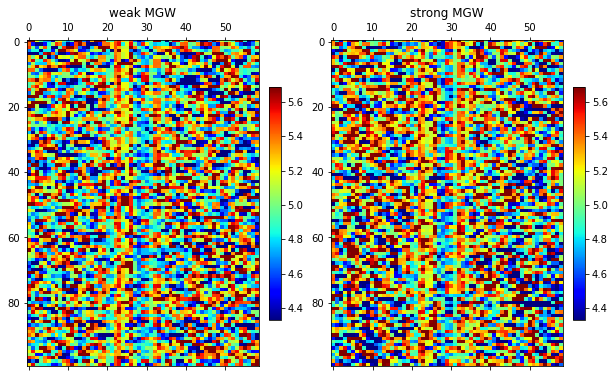

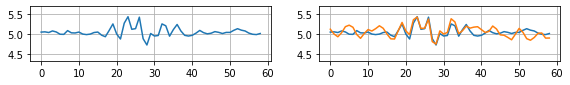

ProT -11.18 -1.95


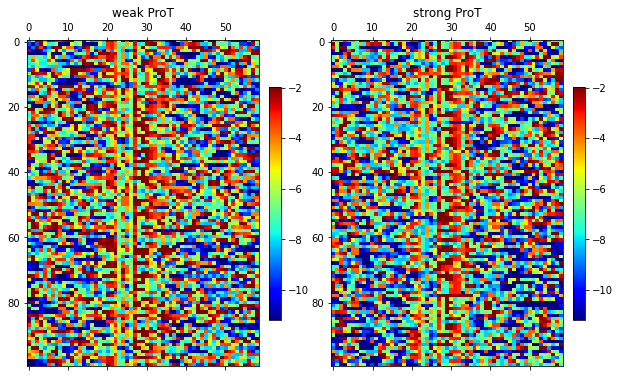

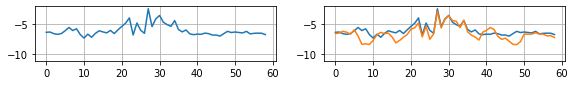

Roll1 -3.91 4.69


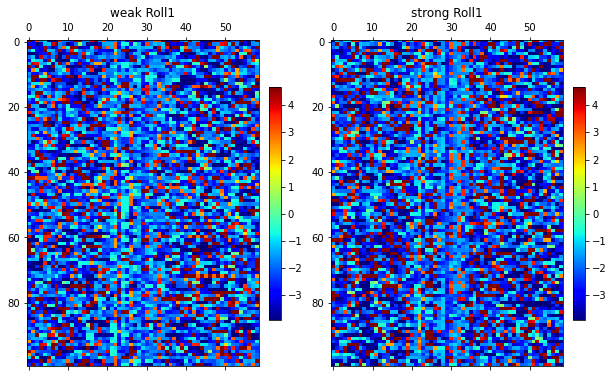

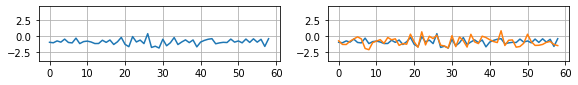

Roll2 -3.96 4.1


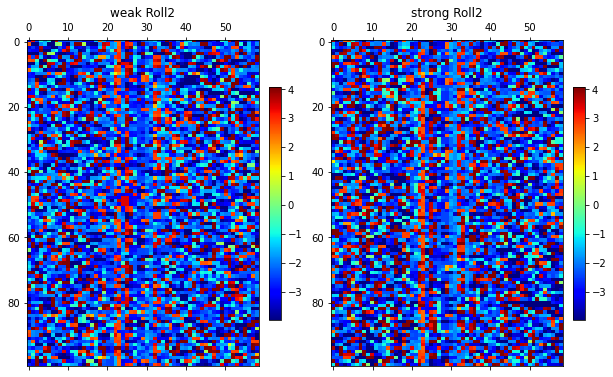

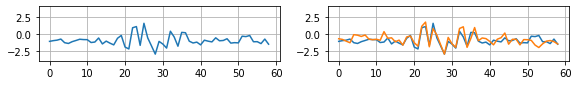

HelT1 31.84 36.59


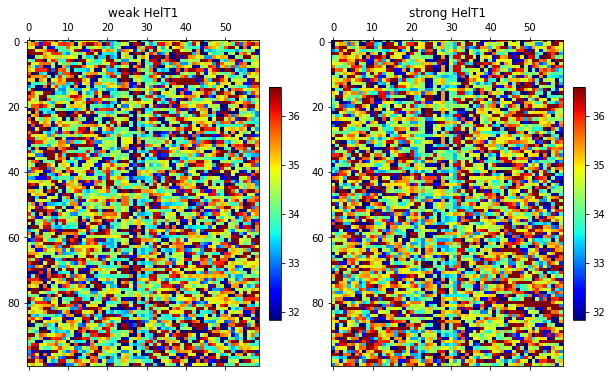

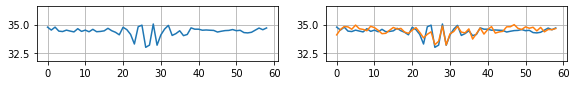

HelT2 31.5 36.26


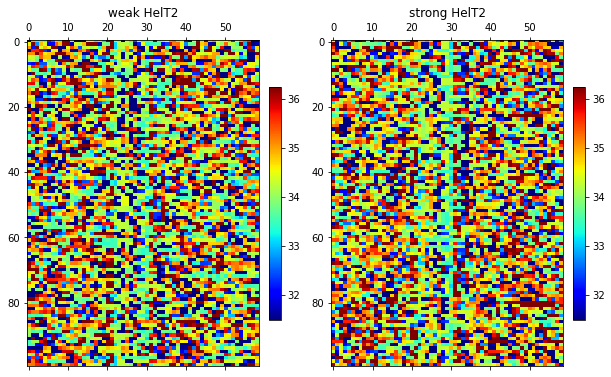

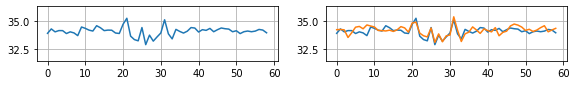

Stretch -0.04 -0.01


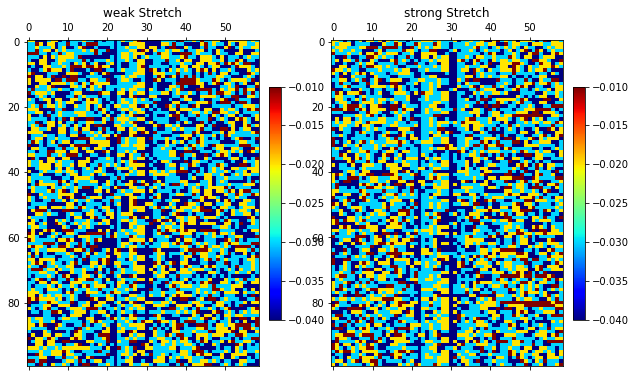

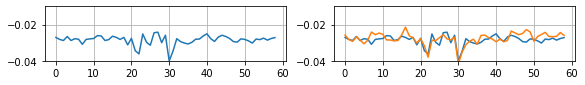

Tilt1 -2.11 1.99


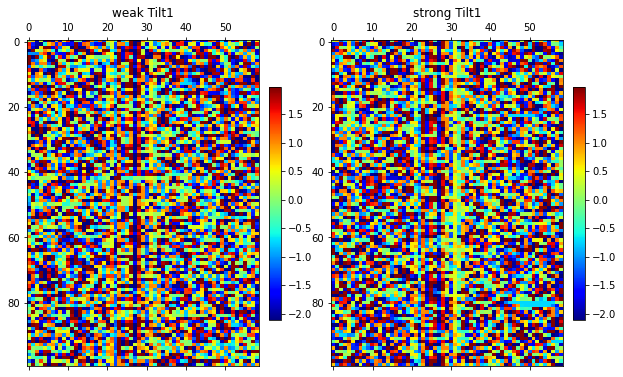

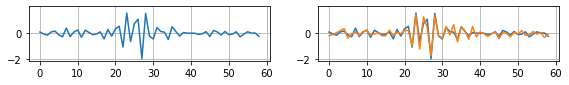

Tilt2 -2.17 2.1


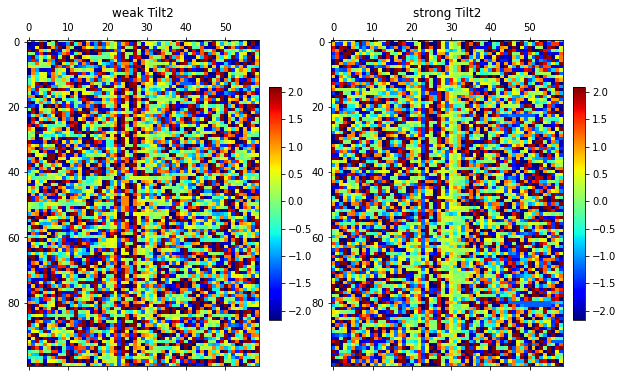

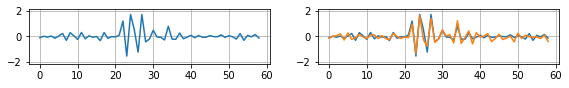

Buckle -3.75 5.8


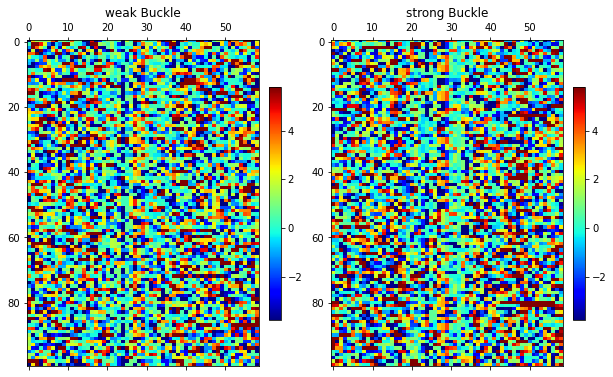

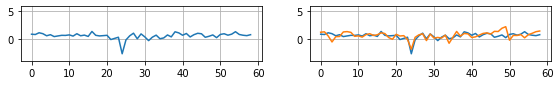

Shear -0.28 0.26


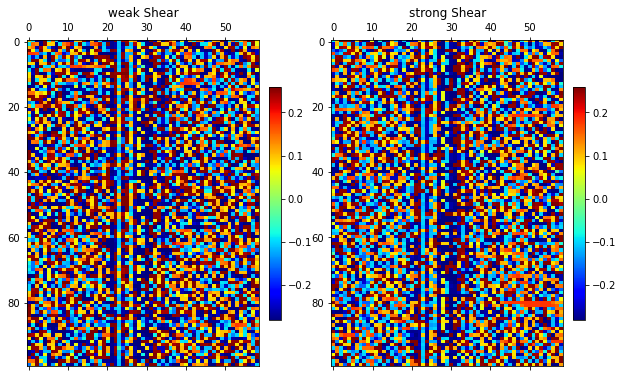

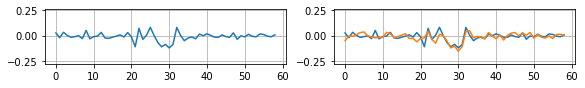

Opening -1.26 0.42


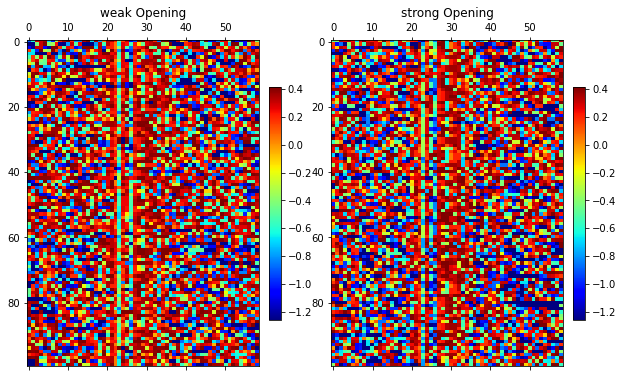

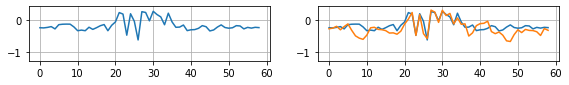

Rise1 3.18 3.49


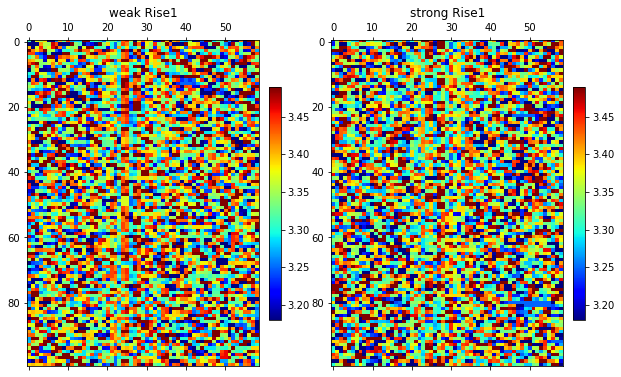

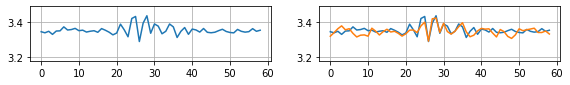

Rise2 3.18 3.47


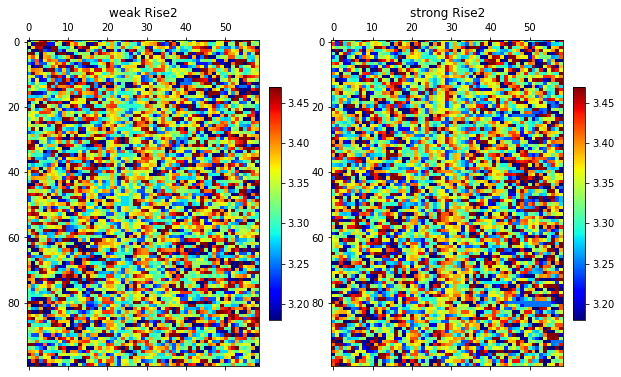

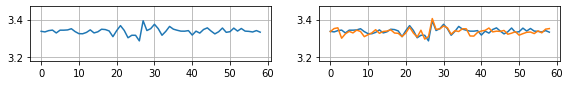

Shift1 -0.27 0.33


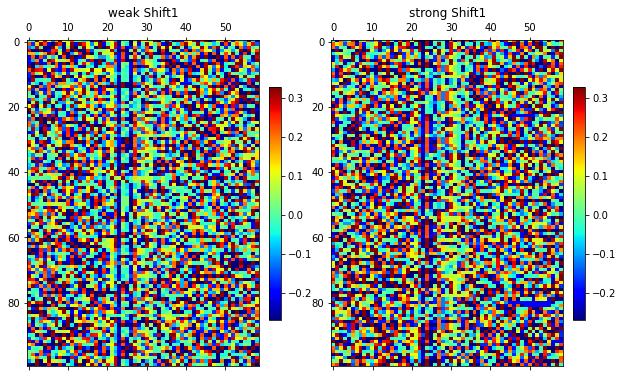

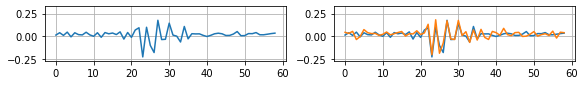

Shift2 -0.27 0.31


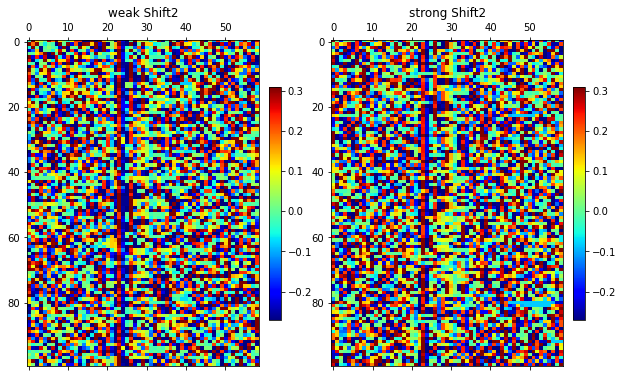

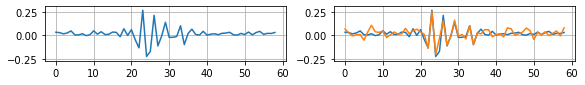

Stagger -0.2 0.13


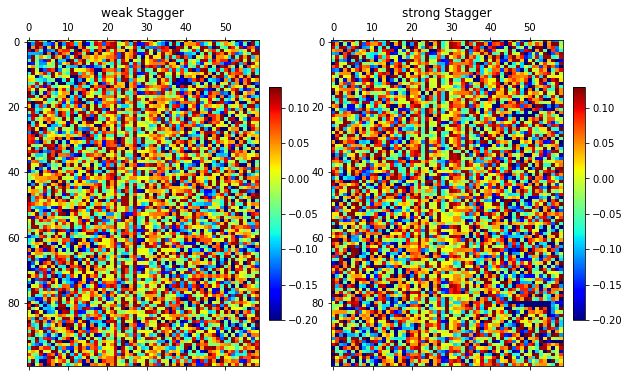

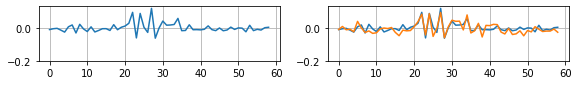

Slide1 -1.82 -1.19


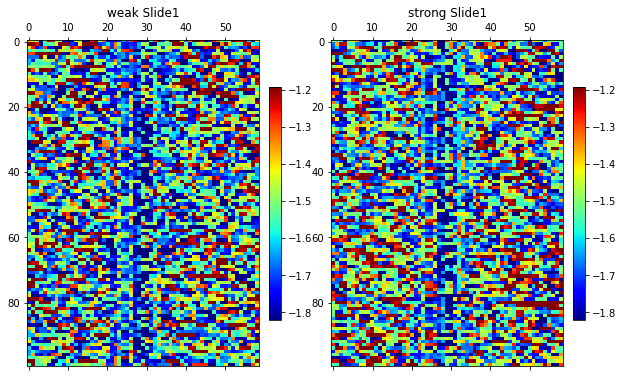

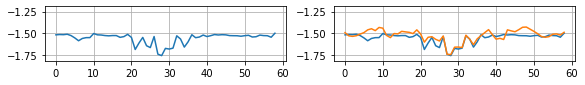

Slide2 -1.81 -1.22


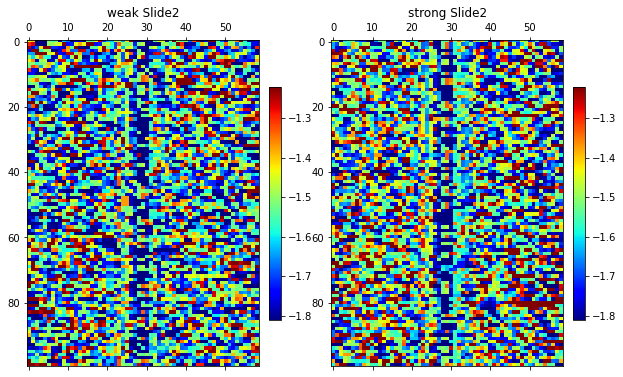

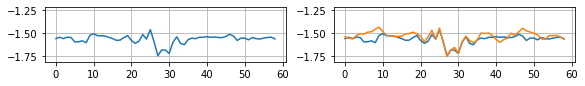

EP -8.21 -5.22


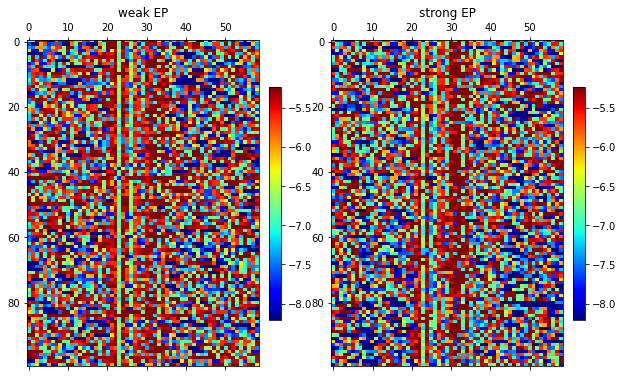

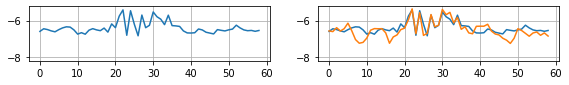

In [22]:
for shape_key in dnashape.keys()[1:]:
    weak_shape, strong_shape = shape_val_dict[shape_key]

    min_val, max_val = np.nanpercentile(
        # [weak_shape , strong_shape ],[5,95])
        [weak_shape, strong_shape],
        [10, 90],
    )
    print(shape_key, min_val, max_val)

    bp_start, bp_stop = (80, 139)

    plt.figure(figsize=(10, 6))
    plt.subplot(121)
    im = plt.matshow(
        weak_shape[:, bp_start:bp_stop],
        vmin=min_val,
        vmax=max_val,
        cmap="jet",
        fignum=False,
    )
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("weak " + str(shape_key))
    ax = plt.gca()
    ax.set_aspect("auto")

    plt.subplot(122)
    im = plt.matshow(
        strong_shape[:, bp_start:bp_stop],
        vmin=min_val,
        vmax=max_val,
        cmap="jet",
        fignum=False,
    )
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("strong " + str(shape_key))
    # plt.tight_layout()
    ax.set_aspect("auto")
    ax = plt.gca()
    ax.set_aspect("auto")
    plt.show()

    plt.figure(figsize=(9.5, 1))
    plt.subplot(121)
    plt.plot(np.mean(weak_shape[:, bp_start:bp_stop], axis=0))
    plt.grid()
    plt.ylim([min_val, max_val])
    plt.subplot(122)
    plt.plot(np.mean(weak_shape[:, bp_start:bp_stop], axis=0))

    plt.plot(np.mean(strong_shape[:, bp_start:bp_stop], axis=0), label="strong")
    plt.grid()
    plt.ylim([min_val, max_val])
    plt.show()

In [9]:
import numpy as np
np.random.permutation([0,1])

array([1, 0])